In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using ForwardDiff
using BenchmarkTools

In [2]:
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
function cov_matr(smpl_tmp)
    smp_fl, w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    smp_fl = smp_fl ./ std(smp_fl, FrequencyWeights(w), 2)
    smp_fl = smp_fl .- mean(smp_fl, FrequencyWeights(w), dims=2)
    cov_m = cov(smp_fl, FrequencyWeights(w), 2)
    return cov_m
end

cov_matr (generic function with 1 method)

In [4]:
@load "../../data/sampling_results/Benchmark-9/mcmc-summary-data.jld" summary_data

1-element Array{Symbol,1}:
 :summary_data

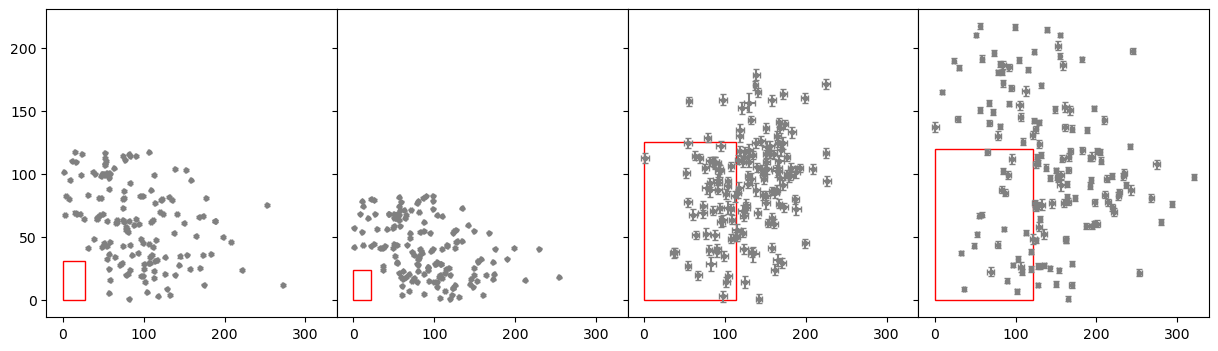

PyObject <matplotlib.patches.Rectangle object at 0x7ff0b9280790>

In [5]:
fig, ax = plt.subplots(1,4, figsize=(15,4), sharex=true, sharey=true)

fig.subplots_adjust(hspace=0.0, wspace=0.0)

x_tmp = [i[1] for i in summary_data.μx_align]
y_tmp = [i[1] for i in summary_data.μy_align]
x_std = [i[1] for i in summary_data.σx_align]
y_std = [i[1] for i in summary_data.σy_align]
ax[1].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")

x_tmp = [i[2] for i in summary_data.μx_align]
y_tmp = [i[2] for i in summary_data.μy_align]
x_std = [i[2] for i in summary_data.σx_align]
y_std = [i[2] for i in summary_data.σy_align]
ax[2].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")

x_tmp = [i[3] for i in summary_data.μx_align]
y_tmp = [i[3] for i in summary_data.μy_align]
x_std = [i[3] for i in summary_data.σx_align]
y_std = [i[3] for i in summary_data.σy_align]
ax[3].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")

x_tmp = [i[4] for i in summary_data.μx_align]
y_tmp = [i[4] for i in summary_data.μy_align]
x_std = [i[4] for i in summary_data.σx_align]
y_std = [i[4] for i in summary_data.σy_align]
ax[4].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")

rect = matplotlib.patches.Rectangle([0,0,], 27.1,30.5,linewidth=1,edgecolor="r",facecolor="none")
ax[1].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  21.6, 23.4,linewidth=1,edgecolor="r",facecolor="none")
ax[2].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  114.0, 125.0,linewidth=1,edgecolor="r",facecolor="none")
ax[3].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  121.8, 120.0,linewidth=1,edgecolor="r",facecolor="none")
ax[4].add_patch(rect)


In [6]:
function predict_position(x0, y0, θ, α; s = Float64[1.478, 15.026, 23.1150])
    x_expected = x0 .+ cos(α).*θ.*s.*10^6
    y_expected = y0 .+ sin(α).*θ.*s.*10^6
    return (x_expected, y_expected)
end

predict_position (generic function with 1 method)

# Sampling: 

In [7]:
sampling_ind = 1:150 #rand(1:length(summary_data.ev_index), 30)
n_events = length(sampling_ind)

prior_ang = NamedTupleDist(
    θ = [10^-15 .. 10^-4 for i in 1:n_events],
    α = [0 .. 2*pi  for i in 1:n_events],
    x_alignm = [-200 .. 200 for i in 1:3],
    y_alignm = [-200 .. 200 for i in 1:3],
    σ = [6.23, 32.9, 35.1],
);

In [8]:
function log_lik(; data = summary_data, event_ind = sampling_ind)
    
    s_cam = Float64[1.478, 15.026, 23.1150]
    
    return params -> begin   
        
        ll = 0.0
    
        for (ind, val) in enumerate(event_ind)
            
            x_expected = cos(params.α[ind]).*params.θ[ind]*s_cam.*10^6
            y_expected = sin(params.α[ind]).*params.θ[ind]*s_cam.*10^6
            
            x_expected += data.μx_align[val][1] .+ params.x_alignm 
            y_expected += data.μy_align[val][1] .+ params.y_alignm
            
#             ll += sum(logpdf.(Normal.(1, params.σ_x), x_expected./data.μx_align[val][2:end] ))
#             ll += sum(logpdf.(Normal.(1, params.σ_y), y_expected./data.μy_align[val][2:end] ))
            
            ll += sum(logpdf.(Normal.(x_expected, params.σ), data.μx_align[val][2:end] ))
            ll += sum(logpdf.(Normal.(y_expected, params.σ), data.μy_align[val][2:end] ))
            
            
        end
        return LogDVal(ll)
    end
        
end

log_likelihood = log_lik()

#82 (generic function with 1 method)

In [9]:
tmp_par = rand(prior_ang)

log_likelihood(tmp_par)

LogDVal{Float64}(-309218.54614581255)

In [10]:
posterior = PosteriorDensity(log_likelihood, prior_ang);

In [11]:
posterior_is = bat_transform(PriorToGaussian(), posterior, PriorSubstitution()).result;

In [12]:
iter = 100000
iter_warmup = 2500
chains = 4;


In [13]:
metric = BAT.DiagEuclideanMetric()
integrator = BAT.LeapfrogIntegrator()
proposal = BAT.NUTS(:MultinomialTS, :ClassicNoUTurn)
adaptor = BAT.StanHMCAdaptor(0.8, iter_warmup)

hmc_sampler = HamiltonianMC(metric, ForwardDiff, integrator, proposal, adaptor);

In [ ]:
@time samples_is = bat_sample(posterior_is, iter, MCMCSampling(sampler = hmc_sampler, nchains = chains));

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63


In [ ]:
# @time samples_is = bat_sample(posterior, 10^6, MCMCSampling(sampler = MetropolisHastings(), nchains = 4));

In [25]:
samples = samples_is.result;

In [26]:
trafo_is = trafoof(posterior_is.likelihood)
samples = inv(trafo_is).(samples);

In [27]:
sz = size(flatview(unshaped.(samples.v)))

(306, 100000)

In [28]:
# BAT.bat_write("../../data/sampling_results/Benchmark-9/samples-1-150.hdf5", unshaped.(samples))

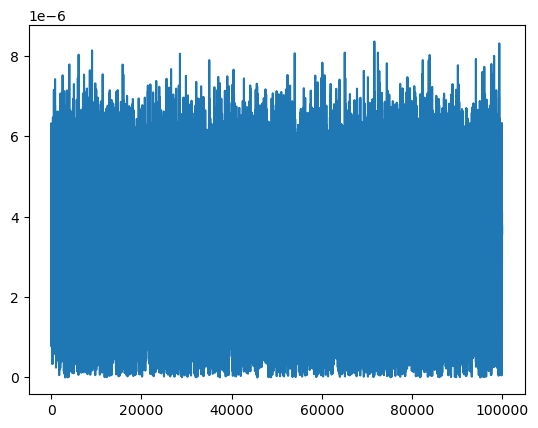

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff0b9d2d850>

In [29]:
plot(flatview(unshaped.(samples.v))[3,:])

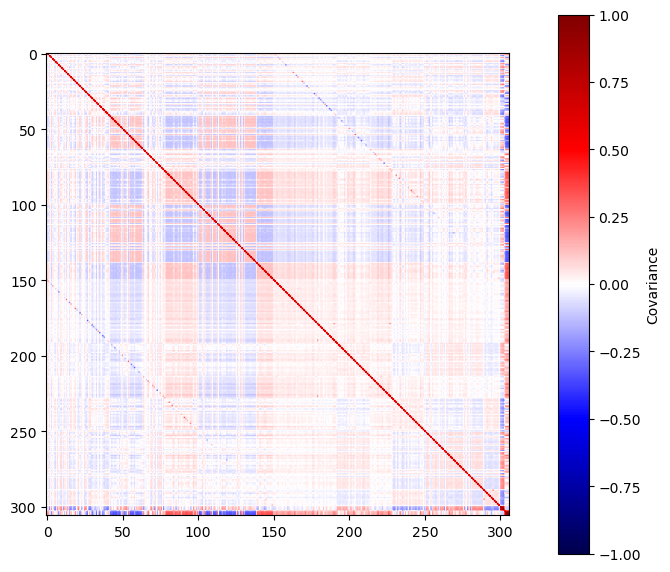

In [30]:
covm = cov_matr(samples);

fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,7), gridspec_kw=Dict("width_ratios"=>[15,1]))

max_tmp = maximum(abs.(covm))

cb = ax.imshow(covm,  origin="upper", cmap="seismic", vmin=-max_tmp, vmax=max_tmp, aspect="equal") 
fig.colorbar(cb, spacing="proportional", label="Covariance", cax=ax2)

# ax.set_yticks(0:26)
# ax.set_yticklabels(labels)

# ax.set_xticks(0:26)
# ax.set_xticklabels(labels, rotation = 90);

In [31]:
param_mode = mode(samples)

ShapedAsNT((θ = [2.3461574683619236e-6, 1.1988087972758211e-6, 2.309260039896627e-6, 2.0213789742565476e-6, 7.310143225020745e-7, 9.69408350829015e-7, 3.142552305760354e-7, 7.888750155628063e-7, 1.9084915153052222e-6, 2.6610472212184973e-6  …  4.086966278680558e-6, 3.8008404265663377e-6, 4.671999013630643e-6, 3.1650992477787103e-6, 4.117944301922267e-6, 5.0041033795869885e-6, 2.7536721418062805e-6, 4.762147947565995e-6, 5.810036001741312e-6, 4.062286390565835e-6], α = [6.209354634065207, 3.5327218673003586, 5.586628463433844, 2.8266756363332735, 5.201820158983004, 1.66069633675247, 5.030738058143045, 3.0906278005014465, 2.535898772218954, 3.4463504453503773  …  5.166081045197207, 4.301440414658501, 4.661440630850551, 4.81253626274324, 5.426673422146778, 5.015703878290175, 4.4786515018143715, 4.95675682839062, 4.6121025446867785, 4.891382337696941], x_alignm = [1.2800236445256132, 47.38301144641096, 70.1843001058985], y_alignm = [-22.8035096730257, 20.442534316521233, 29.530710758907077

In [32]:
bat_marginalmode(samples).result

ShapedAsNT((θ = [2.5250000000000004e-6, 4.2499999999999995e-7, 3.275e-6, 2.125e-6, 1.25e-7, 4.75e-7, 2.725e-6, 1.9749999999999997e-6, 3.2499999999999996e-7, 2.925e-6  …  5.125e-6, 5.425e-6, 5.2500000000000006e-6, 4.775e-6, 4.574999999999999e-6, 4.425e-6, 5.1750000000000004e-6, 5.725e-6, 5.925e-6, 3.725e-6], α = [5.625, 3.925, 0.025, 2.325, 4.574999999999999, 0.025, 0.175, 3.675, 1.775, 3.625  …  5.13, 4.35, 4.83, 4.93, 5.324999999999999, 5.025, 4.63, 4.85, 4.65, 4.875], x_alignm = [0.675, 42.75, 61.25], y_alignm = [-22.424999999999997, 21.75, 30.25], σ = [6.23, 32.9, 35.1]))

In [33]:
mean(samples)[1]

(θ = [2.4598949061006655e-6, 1.5664194031496217e-6, 3.2482825972296325e-6, 2.1574284302967215e-6, 1.1309216187606025e-6, 1.4815619886330569e-6, 2.8208756083596057e-6, 2.1151349816996446e-6, 1.5868389758075646e-6, 2.702269114740422e-6  …  5.339575245331054e-6, 5.288083147871474e-6, 4.928773447858283e-6, 5.03408005564943e-6, 4.633241944153384e-6, 4.280674206276178e-6, 5.192999632548717e-6, 5.546457795602187e-6, 5.942094553558949e-6, 3.581475125752983e-6], α = [4.812290734870431, 3.7803486157404507, 3.632194355435905, 2.4665772031284274, 3.6467332097536262, 3.212281394660466, 2.341100601787361, 3.5026879018786894, 2.251199886068181, 3.6871542498023664  …  5.1492133102504525, 4.324062834690239, 4.824530373237389, 4.8856542437613975, 5.310141239949365, 4.9937021945283115, 4.616641425882643, 4.821594342358944, 4.639183479452092, 4.83707889786858], x_alignm = [0.6380016376211263, 43.935109885904026, 60.47251482610378], y_alignm = [-22.509521083637043, 21.352182555806376, 30.26880915016054], σ

In [34]:
std(samples)[1]

(θ = [1.269490078488653e-6, 1.0681827989471057e-6, 1.309168468807345e-6, 1.2280009524428212e-6, 8.456926746110037e-7, 1.026306900028963e-6, 1.2902639444387e-6, 1.2116577354605704e-6, 1.075405055398049e-6, 1.2906430454762698e-6  …  1.2951053170952436e-6, 1.296348612659488e-6, 1.3083172455629133e-6, 1.3029152886828e-6, 1.2973531509608961e-6, 1.3316496135325383e-6, 1.2962814814922238e-6, 1.2936723548173682e-6, 1.2942306106478528e-6, 1.332408184643573e-6], α = [1.7843236542865486, 1.1909850558270436, 2.7557600773185302, 0.8582803146117535, 1.6442083267924485, 2.367449907316459, 2.6111996337652816, 0.8571343988485802, 1.2673702796506179, 0.6328864556739804  …  0.24147656297676842, 0.24544917813641987, 0.2665028843368055, 0.258787428804254, 0.2841922993611173, 0.41096954971868777, 0.2515161341576633, 0.23080498331572252, 0.21536326505839887, 0.4917855480468461], x_alignm = [0.6867595441515213, 5.4798778017809315, 7.894992716187315], y_alignm = [0.8111109744221626, 6.942383701826252, 10.26495

In [ ]:
#  findmode_result = bat_findmode(posterior, MaxDensityLBFGS(init = InitFromTarget()), )

findmode_result = bat_findmode(
    posterior, 
    MaxDensityLBFGS(init = ExplicitInit([param_mode],)), 
)

fit_par_values = findmode_result.result[1]

In [ ]:
# @save "../../data/sampling_results/Benchmark-5/alignment/hc-data.jld2" data fit_par_values

In [ ]:
dims = 1:n_events
# dims = [1,2,3,4,5,]
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 30

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = n_events+1:2*n_events
# dims = [1,2,3,4,5,]
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 25

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

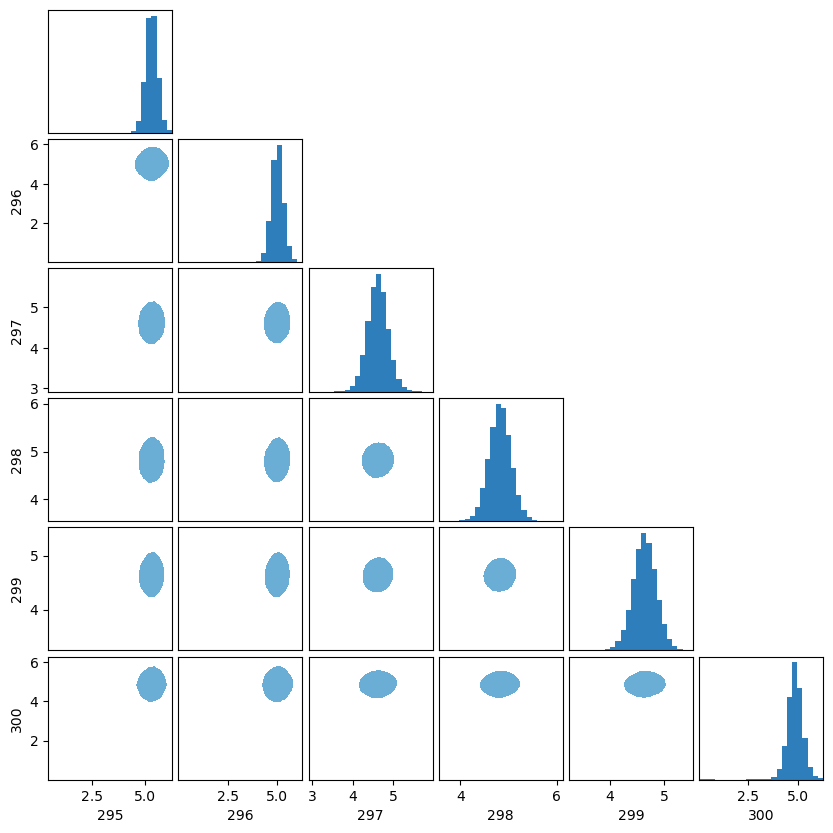

In [35]:
dims = collect(sz[1]-11:sz[1]-6)
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.95, 1,]
figsize = (10,10)
n_bins = 25

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

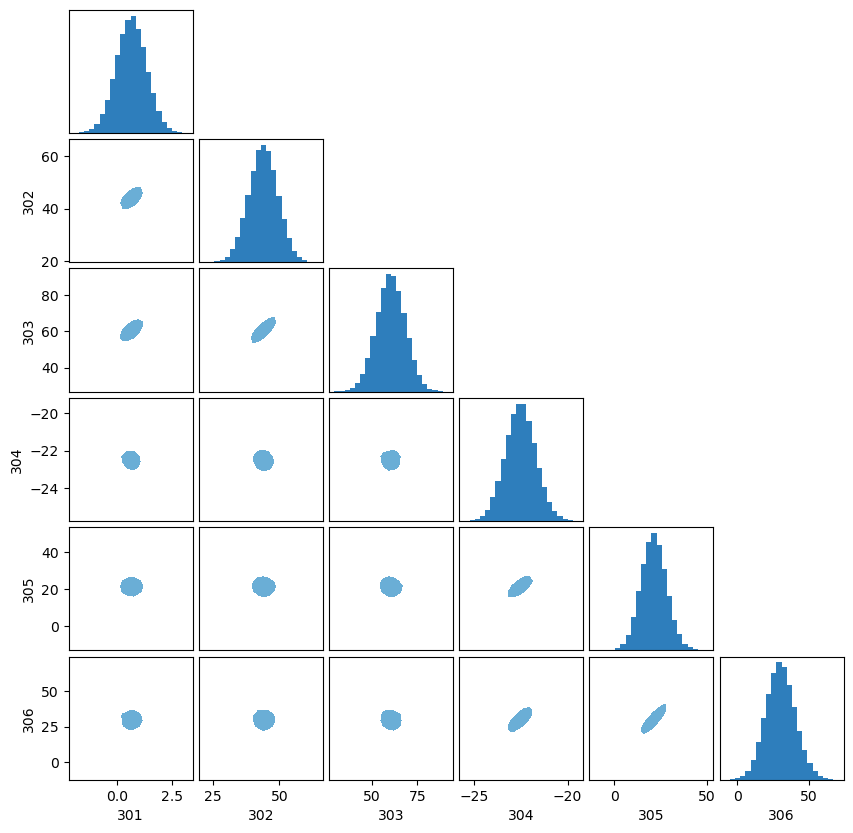

In [36]:
dims = collect(sz[1]-5:sz[1])
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 25

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [39]:
function predict_position(x0, y0, θ, α; s = Float64[1.478, 15.026, 23.1150])
    x_expected = x0 .+ cos(α).*θ.*s.*10^6
    y_expected = y0 .+ sin(α).*θ.*s.*10^6
    return (x_expected, y_expected)
end

predict_position (generic function with 1 method)

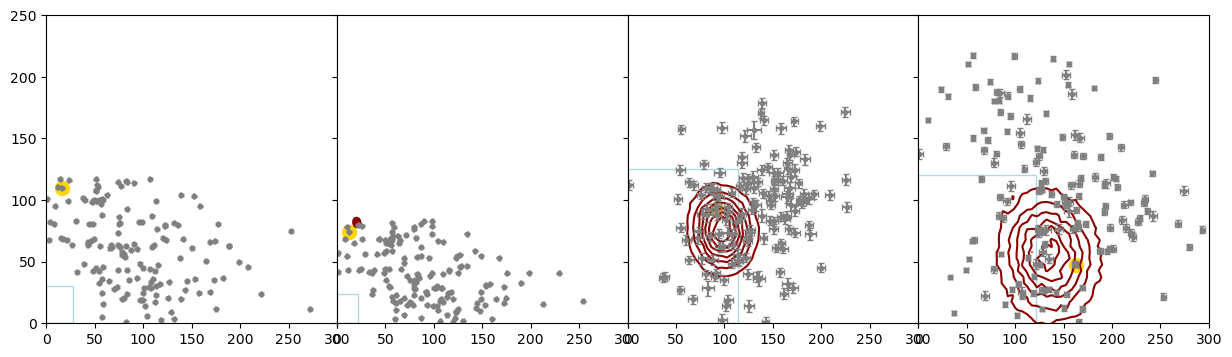

(0.0, 250.0)

In [151]:
par_ind = 145 # 9, 104, 118, 120, 140
event_ind = sampling_ind[par_ind]

fig, ax = plt.subplots(1,4, figsize=(15,4), sharex=true, sharey=true)

fig.subplots_adjust(hspace=0.0, wspace=0.0)

x_tmp = [i[2] for i in summary_data.μx_align]
y_tmp = [i[2] for i in summary_data.μy_align]
x_std = [i[2] for i in summary_data.σx_align]
y_std = [i[2] for i in summary_data.σy_align]
ax[2].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")
ax[2].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

x_tmp = [i[3] for i in summary_data.μx_align]
y_tmp = [i[3] for i in summary_data.μy_align]
x_std = [i[3] for i in summary_data.σx_align]
y_std = [i[3] for i in summary_data.σy_align]
ax[3].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")
ax[3].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

x_tmp = [i[4] for i in summary_data.μx_align]
y_tmp = [i[4] for i in summary_data.μy_align]
x_std = [i[4] for i in summary_data.σx_align]
y_std = [i[4] for i in summary_data.σy_align]
ax[4].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")
ax[4].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

x_tmp = [i[1] for i in summary_data.μx_align]
y_tmp = [i[1] for i in summary_data.μy_align]
x_std = [i[1] for i in summary_data.σx_align]
y_std = [i[1] for i in summary_data.σy_align]
ax[1].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")
ax[1].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

rect = matplotlib.patches.Rectangle([0,0,], 27.1,30.5,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[1].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  21.6, 23.4,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[2].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  114.0, 125.0,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[3].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  121.8, 120.0,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[4].add_patch(rect)

v1 = Float64[]
v2 = Float64[]
v3 = Float64[]
v4 = Float64[]
v5 = Float64[]
v6 = Float64[]
 
for i in samples.v
    pred_x, pred_y = predict_position(x_tmp[event_ind], y_tmp[event_ind], i.θ[par_ind], i.α[par_ind])
    pred_x += i.x_alignm
    pred_y += i.y_alignm
    
    push!(v1, pred_x[1])
    push!(v2, pred_y[1])
    
    push!(v3, pred_x[2])
    push!(v4, pred_y[2])
    
    push!(v5, pred_x[3])
    push!(v6, pred_y[3])
end

hist_tmp_1 = fit(Histogram, (v1, v2), FrequencyWeights(samples.weight), nbins=50)
hist_tmp_2 = fit(Histogram, (v3, v4), FrequencyWeights(samples.weight), nbins=50)
hist_tmp_3 = fit(Histogram, (v5, v6), FrequencyWeights(samples.weight), nbins=50)

ax[2].contour(midpoints(hist_tmp_1.edges[1]), midpoints(hist_tmp_1.edges[2]), broadcast(x-> x>1 ? x : NaN, hist_tmp_1.weights)', 
    colors="darkred", alpha=1, antialiased=true) 

ax[3].contour(midpoints(hist_tmp_2.edges[1]), midpoints(hist_tmp_2.edges[2]), broadcast(x-> x>1 ? x : NaN, hist_tmp_2.weights)', 
    colors="darkred", alpha=1, antialiased=true)

ax[4].contour(midpoints(hist_tmp_3.edges[1]), midpoints(hist_tmp_3.edges[2]), broadcast(x-> x>1 ? x : NaN, hist_tmp_3.weights)', 
    colors="darkred", alpha=1, antialiased=true)

ax[1].set_xlim(0, 300)
ax[1].set_ylim(0, 250)

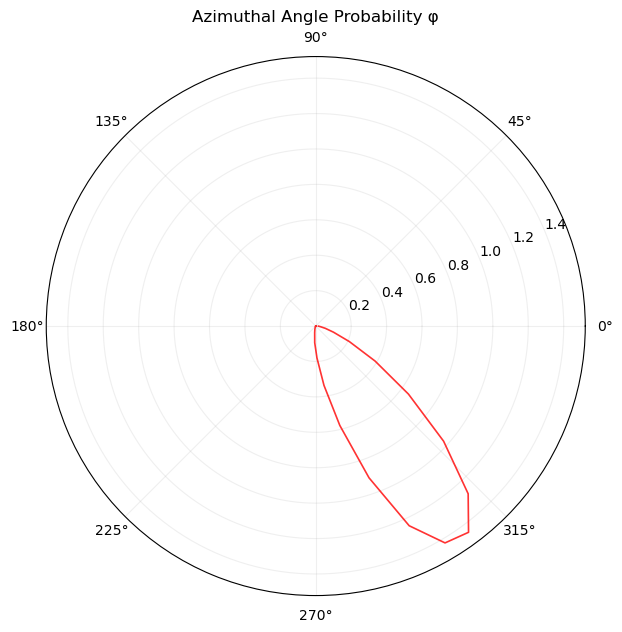

PyObject Text(0.5, 1.05, 'Azimuthal Angle Probability φ')

In [152]:
dt = Float64[i[par_ind] for i in samples.v.α]
hist_v = fit(Histogram, dt, FrequencyWeights(round.(Int64, samples.weight)), nbins=100)
hist_v = normalize(hist_v, mode=:pdf)

fig = figure(figsize=(7,7))

ax = PyPlot.axes(polar="true") # Create a polar axis

ax.plot(midpoints(hist_v.edges[1]), 
        hist_v.weights, 
        lw=1.2,  "o-", 
        color= "red", 
        alpha=0.8, 
        marker="None") 


ax.grid(alpha=0.2)
# ax.set_yticklabels([])
ax.set_title("Azimuthal Angle Probability φ")